# Retail Sales Forecasting

### Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

# CatBoost is a high-performance open source library for gradient boosting on decision trees
from catboost import CatBoostRegressor, Pool, cv
from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# shap is a unified approach to explain the output of any machine learning model.
import shap
shap.initjs()

### Read DataSet

In [2]:
data = pd.read_csv("E:/AMotefaker/ABC/Data Analyst/Sales Data Analysis/Retail Sales Forecasting/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})

In [3]:
data.shape

(541909, 8)

- The data has 541909 entries and 8 variables.

### Familiarity with data

In [4]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


- We can see that the datafile has information given for each single transaction. 
- Take a look at the InvoiceNo and the CustomerID of the first entries. Here we can see that one customer with ID 17850 of the United Kingdom made a single order that has the InvoideNo 536365.
- The customer ordered several products with different stockcodes, descriptions, unit prices and quantities. 
- We can see that the InvoiceDate was the same for these products.

### Data Exploration

#### Missing values 

In [5]:
# How many % of missing values do we have for each feature?
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

- Almost 25 % of the customers are unknown! That's very strange. 
- In addition we have 0.2 % of missing descriptions. This looks dirty.

##### Let's gain a further impression by considering some examples:

#### Missing descriptions

In [6]:
data[data.Description.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [7]:
# How often do we miss the customer as well?
data[data.Description.isnull()].CustomerID.isnull().value_counts()

True    1454
Name: CustomerID, dtype: int64

In [8]:
# unit price?
data[data.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

- In cases of missing descriptions we always miss the customer and the unit price as well. Why does the retailer records such kind of entries without a further description?
-  It seems that there is no sophisticated procedure how to deal with and record such kind of transactions. This is already a hint that we could expect strange entries in our data and that it can be difficult to detect them!

#### Missing Customer IDs

In [9]:
data[data.CustomerID.isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [10]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()

,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


- The price and the quantities of entries without a customer ID can show extreme outliers. 
- As we might want to create features later on that are based on historical prices and sold quantities, this is very disruptive. 
- Our first advice for the retailer is to setup strategies for transactions that are somehow faulty or special. 
- Why is it possible for a transaction to be without a customer ID? Perhaps you can purchase as a quest but then it would of a good and clean style to plugin a special ID that indicates that this one is a guest.

#### Hidden missing descriptions

In [11]:
# Can we find "nan"-Strings?
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

False    539724
True        731
Name: lowercase_descriptions, dtype: int64

In [12]:
# Can we find empty ""-strings?
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

False    540455
Name: lowercase_descriptions, dtype: int64

#### We found additional, hidden nan-values that show a string "nan" instead of a nan-value. Let's transform them to NaN:

In [13]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

- We don't know why customers or descriptions are missing and we have seen strange outliers in quantities and prices as well as zero prices.
- Drop all of these occurrences.

In [14]:
data = data.loc[(data.CustomerID.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

In [15]:
# Is there a missing value left?
data.isnull().sum().sum()

0

#### The Time period 

In [16]:
# How long is the period in days?
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [17]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


#### The invoice number

In [18]:
# How many different invoice numbers do we have?
data.InvoiceNo.nunique()

22186

#### In the data description, we can find that a canceled transaction starts with a "C" in front of it. Let's create a feature to easily filter out these cases:

In [19]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

False    97.81007
True      2.18993
Name: IsCancelled, dtype: float64

- About 2.2% of all entries are cancellations.

In [20]:
data.loc[data.IsCancelled==True].describe()

,Quantity,UnitPrice
count,8896.000000,8896.000000
mean,-30.882981,18.862815
std,1170.746458,444.590459
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


- All cancellations have negative quantities but positive, non-zero unit prices. 
- Given this data, we are not easily able to understand why a customer made a return and it's very difficult to predict such cases as there could be several, hidden reasons why a cancellation was done.
- Let's drop them:

In [21]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

#### Stock Codes

In [22]:
# How many unique stockcodes do we have?
data.StockCode.nunique()

3663

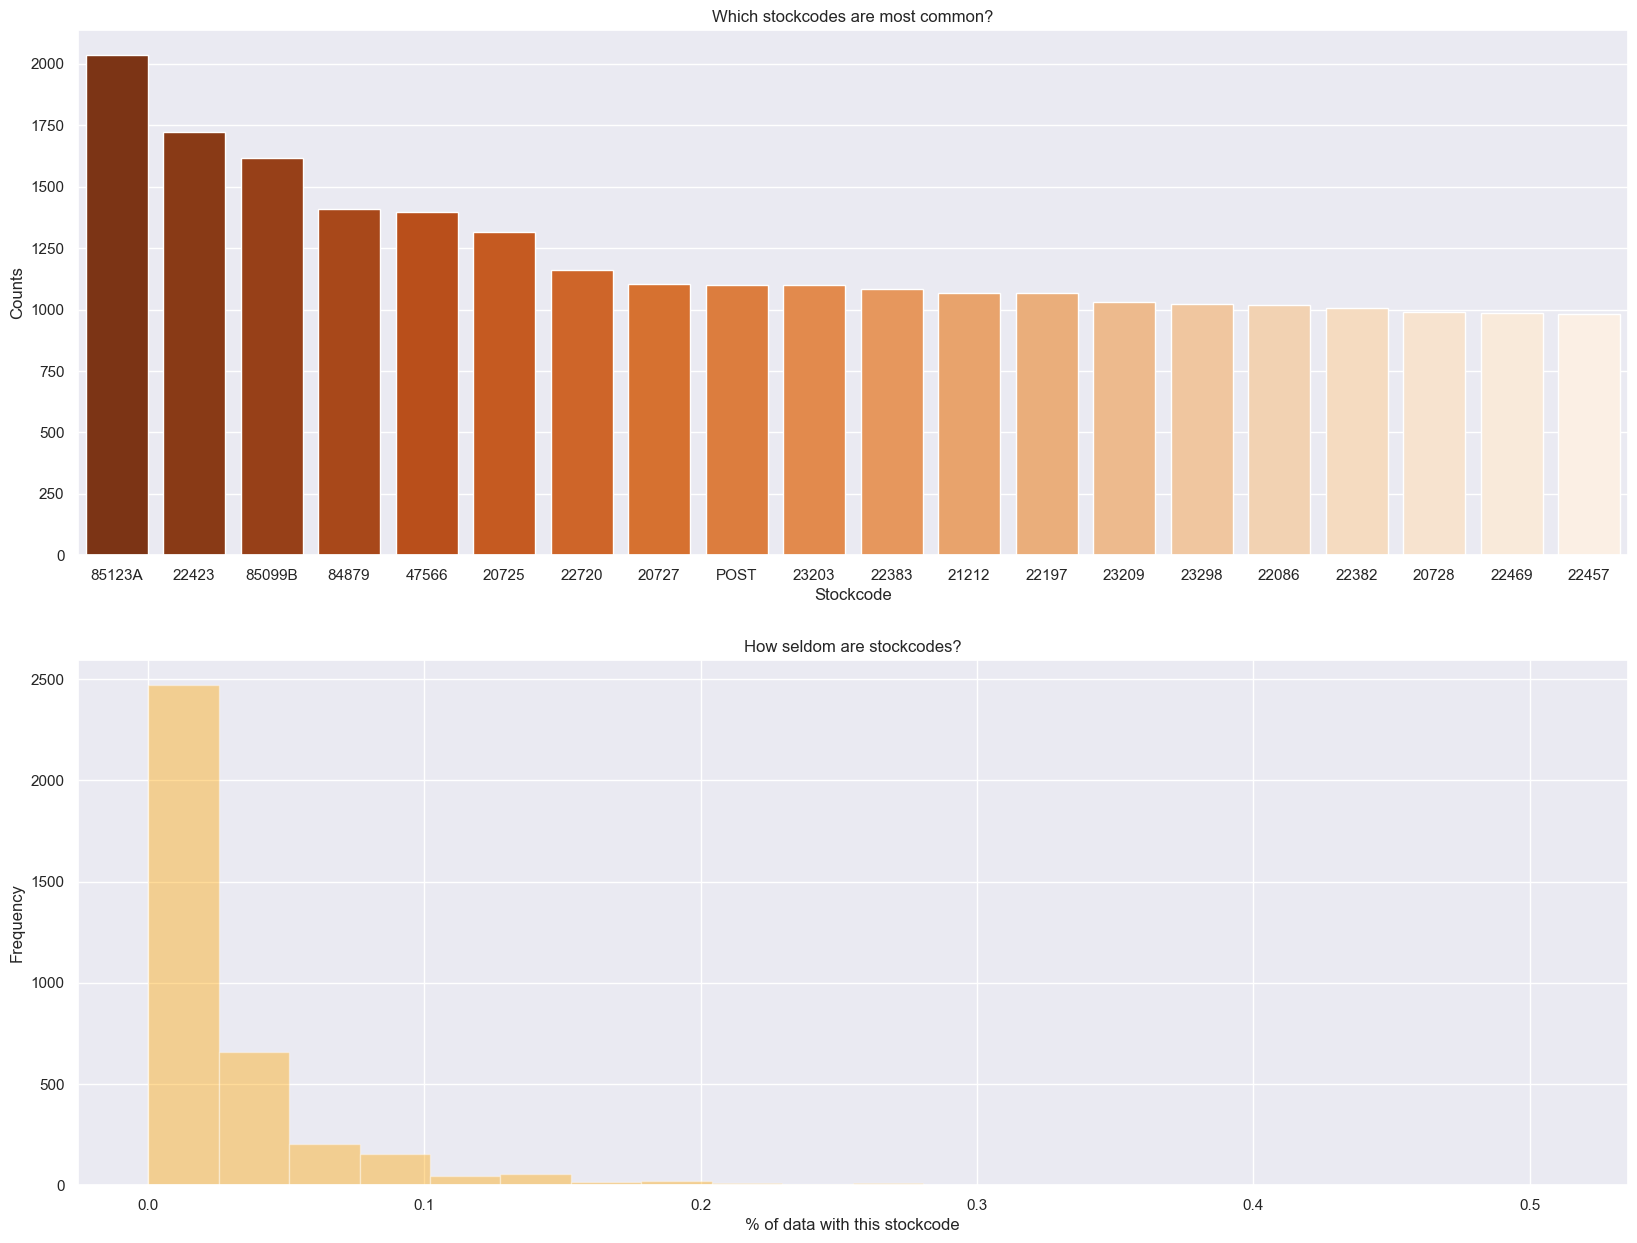

In [25]:
# Which stock codes are most common?
# How seldom are stock codes?
stockcode_counts = data.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            ax = ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

#### Tips:
- Do you have the POST in the most common stock code counts?! 
- Hence we could expect strange occurrences not only in the descriptions and customers but also in the stock code. 
- Its code is shorter than the others as well as not numeric.
- Most stock codes are very seldom. This indicates that the retailer sells many different products and that there is no strong specialization of a specific stock code. Nevertheless we have to be careful as this must not mean that the retailer is not specialized given a specific product type. 
- The stock code could be a very detailed indicator that does not yield information about the type, for example, water bottles may have very different variants in color, name, and shapes but they are all water bottles.

#### Count the number of numeric chars in and the length of the stock code:

In [64]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

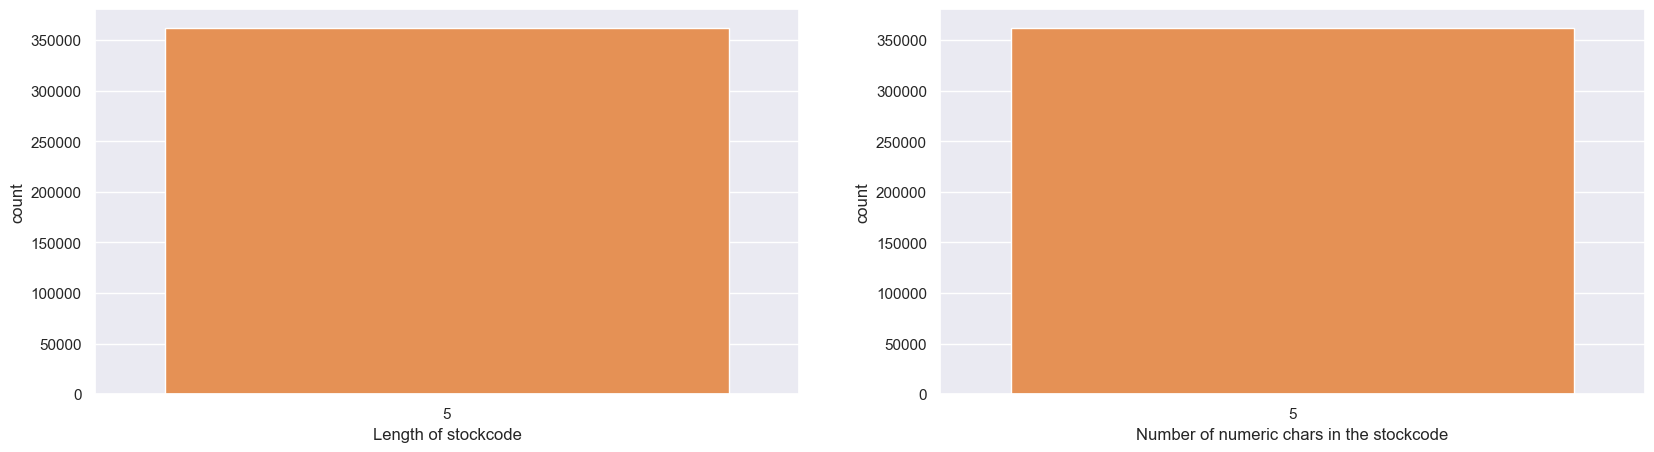

In [65]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(x=data["StockCodeLength"], palette="Oranges_r", ax=ax[0])
sns.countplot(x=data["nNumericStockCode"], palette="Oranges_r", ax=ax[1])
ax[0].set_xlabel("Length of stockcode")
ax[1].set_xlabel("Number of numeric chars in the stockcode");

- Even though the majority of samples has a stockcode that consists of 5 numeric chars, we can see that there are other occurences as well.
- The length can vary between 1 and 12 and there are stockcodes with no numeric chars at all!

In [36]:
data.loc[data.nNumericStockCode < 5].lowercase_descriptions.value_counts()

postage                       1099
manual                         290
carriage                       133
dotcom postage                  16
bank charges                    12
pads to match all cushions       4
Name: lowercase_descriptions, dtype: int64

- Something that we don't want to predict. 
- This indicates that the retailer does not separate well between special kinds of transactions and valid customer-retailer transactions. 
- Let's drop all of these occurrences:

In [37]:
data = data.loc[(data.nNumericStockCode == 5) & (data.StockCodeLength==5)].copy()
data.StockCode.nunique()

2783

In [38]:
data = data.drop(["nNumericStockCode", "StockCodeLength"], axis=1)

In [39]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,white metal lantern
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,set 7 babushka nesting boxes
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,glass star frosted t-light holder
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,hand warmer union jack
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,hand warmer red polka dot


#### Descriptions 

In [40]:
# How many unique descriptions do we have?
data.Description.nunique()

2983

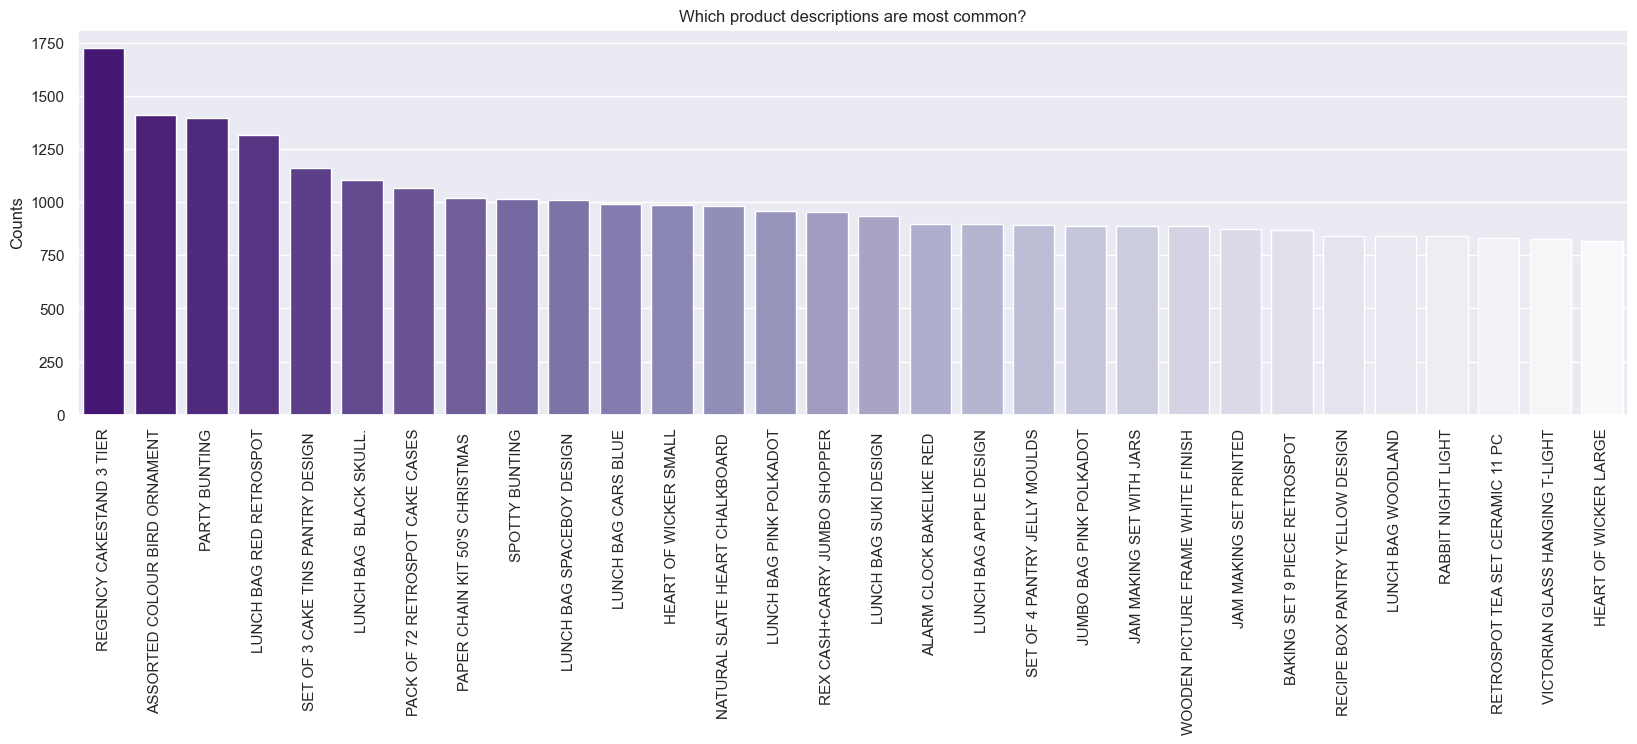

In [42]:
# Which are most common?
description_counts = data.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(x=description_counts.index, y=description_counts.values, palette="Purples_r")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

- We can see that some descriptions correspond to a similar product type.
- Do you see the multiple occurrences of lunch bags? 
- We often have color information about the product as well.
- The most common descriptions seem to confirm that the retailer sells various kinds of products. 
- All descriptions seem to consist of uppercase chars. 
- Now let's do some additional analysis on the descriptions by counting the length and the number of lowercase chars.

In [66]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [67]:
data["DescriptionLength"] = data.Description.apply(lambda l: len(l))
data["LowCharsInDescription"] = data.Description.apply(lambda l: count_lower_chars(l))

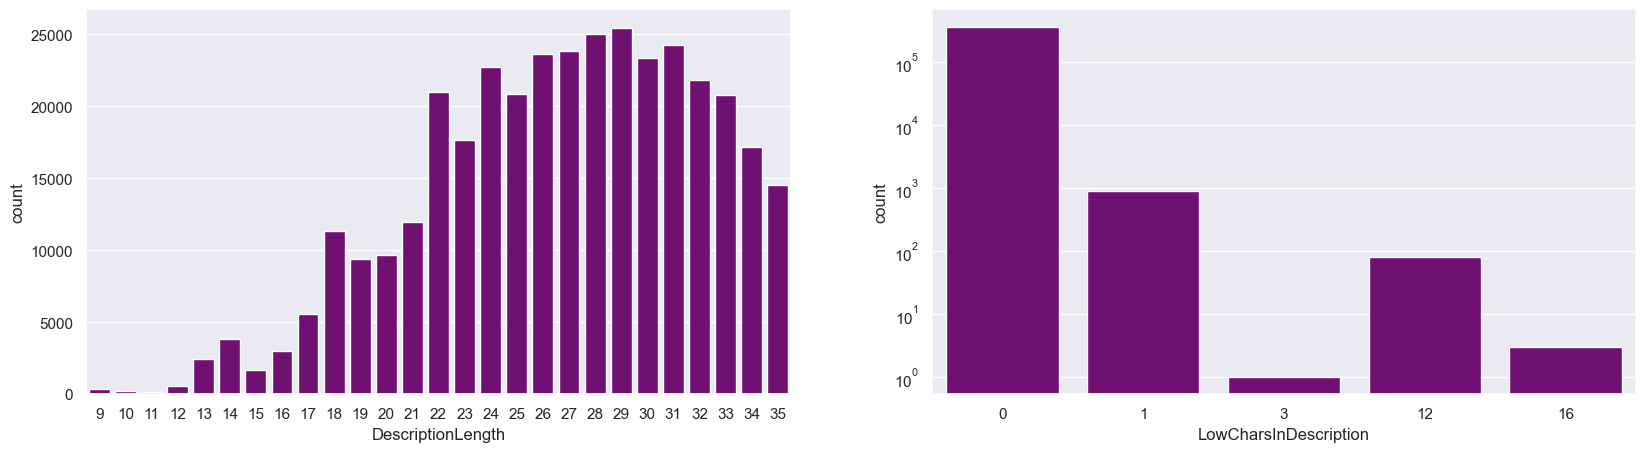

In [68]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(x=data.DescriptionLength, ax=ax[0], color="Purple")
sns.countplot(x=data.LowCharsInDescription, ax=ax[1], color="Purple")
ax[1].set_yscale("log")

- That's great! Almost all descriptions do not have a lowercase char, but we have found exceptional cases!

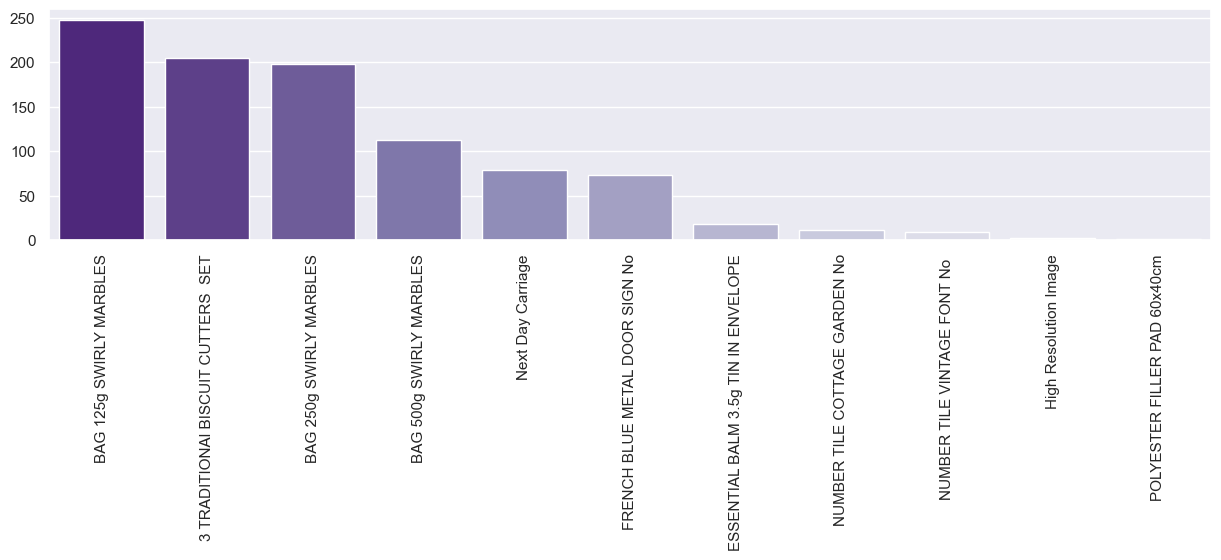

In [70]:
lowchar_counts = data.loc[data.LowCharsInDescription > 0].Description.value_counts()

plt.figure(figsize=(15,3))
sns.barplot(x=lowchar_counts.index, y=lowchar_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

#### Compute the fraction of lower concerning uppercase letters:

In [71]:
def count_upper_chars(l):
    return sum(1 for c in l if c.isupper())

data["UpCharsInDescription"] = data.Description.apply(lambda l: count_upper_chars(l))

In [72]:
data.UpCharsInDescription.describe()

count    362522.000000
mean         22.572291
std           4.354845
min           3.000000
25%          20.000000
50%          23.000000
75%          26.000000
max          32.000000
Name: UpCharsInDescription, dtype: float64

In [73]:
data.loc[data.UpCharsInDescription <=5].Description.value_counts()

Next Day Carriage        79
High Resolution Image     3
Name: Description, dtype: int64

- It's strange that they differ from the others. 
- Let's drop them:

In [74]:
data = data.loc[data.UpCharsInDescription > 5].copy()

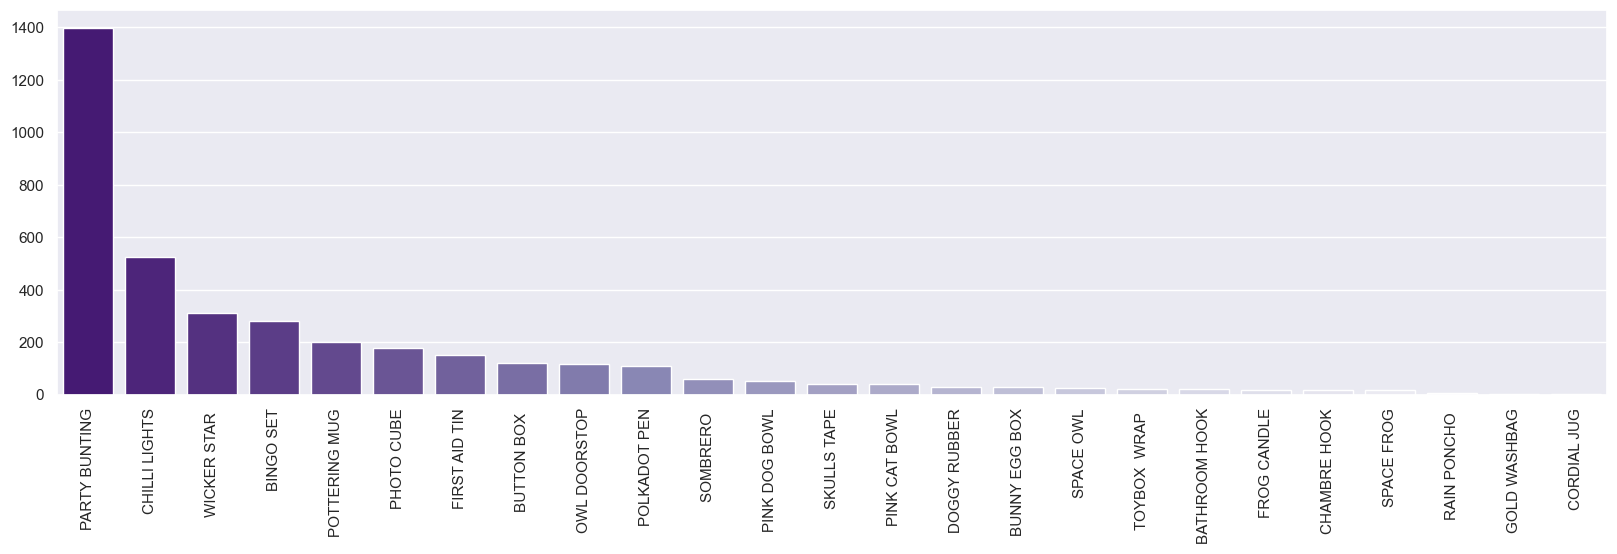

In [76]:
# what about the descriptions with a length below 14?
dlength_counts = data.loc[data.DescriptionLength < 14].Description.value_counts()

plt.figure(figsize=(20,5))
sns.barplot(x=dlength_counts.index, y=dlength_counts.values, palette="Purples_r")
plt.xticks(rotation=90);

- Descriptions with small lengths look valid and we should not drop them.

#### Now let's see how many unique stock codes we have and how many unique descriptions:

In [77]:
data.StockCode.nunique()

2781

In [78]:
data.Description.nunique()

2981

- We still have more descriptions than stock codes and we should continue to find out why they differ.

In [79]:
data.groupby("StockCode").Description.nunique().sort_values(ascending=False).iloc[0:10]

StockCode
23236    4
23196    4
23413    3
23244    3
23126    3
23203    3
23209    3
23366    3
23131    3
23535    3
Name: Description, dtype: int64

- We still have stock codes with multiple descriptions.
- Let's look at an example:

In [80]:
data.loc[data.StockCode == "23244"].Description.value_counts()

ROUND STORAGE TIN VINTAGE LEAF    96
STORAGE TIN VINTAGE LEAF           7
CANNISTER VINTAGE LEAF DESIGN      2
Name: Description, dtype: int64

- OK, browsing through the cases we can see that stock codes are sometimes called a bit differently due to missing or changed words or typing errors. 
- They look ok and we can continue.

### Customers 

In [81]:
data.CustomerID.nunique()

4315

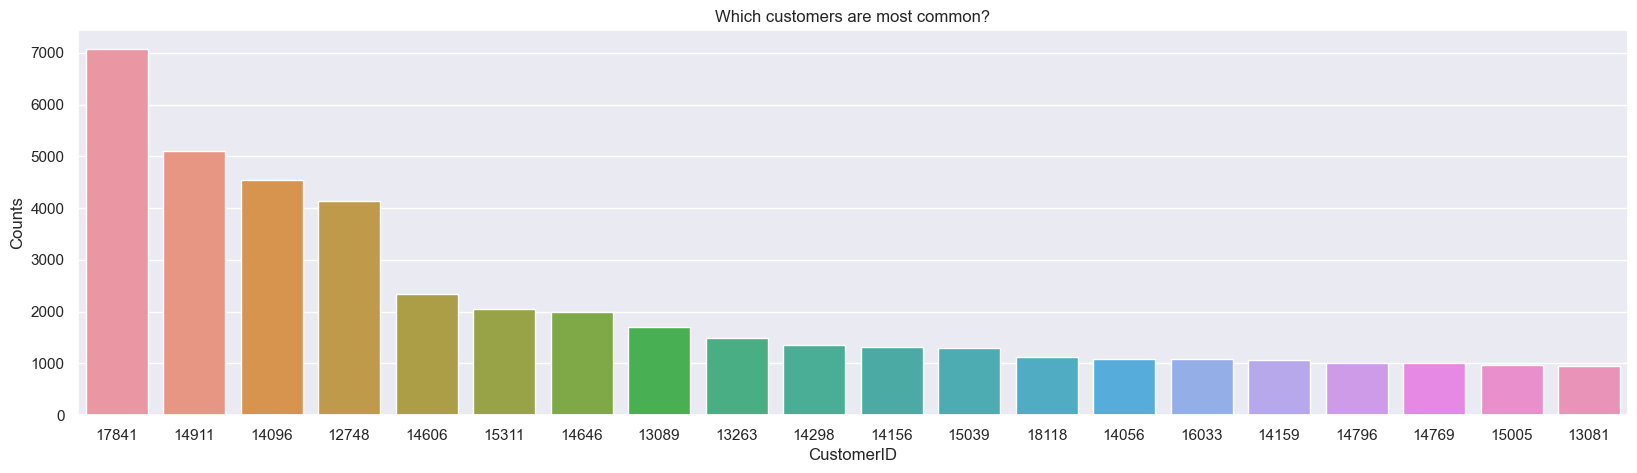

In [84]:
# Which customers are most common?
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(x=customer_counts.index, y=customer_counts.values, order=customer_counts.index)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

### Countries 

In [85]:
# How many unique countries are delivered by the retailer?
data.Country.nunique()

37

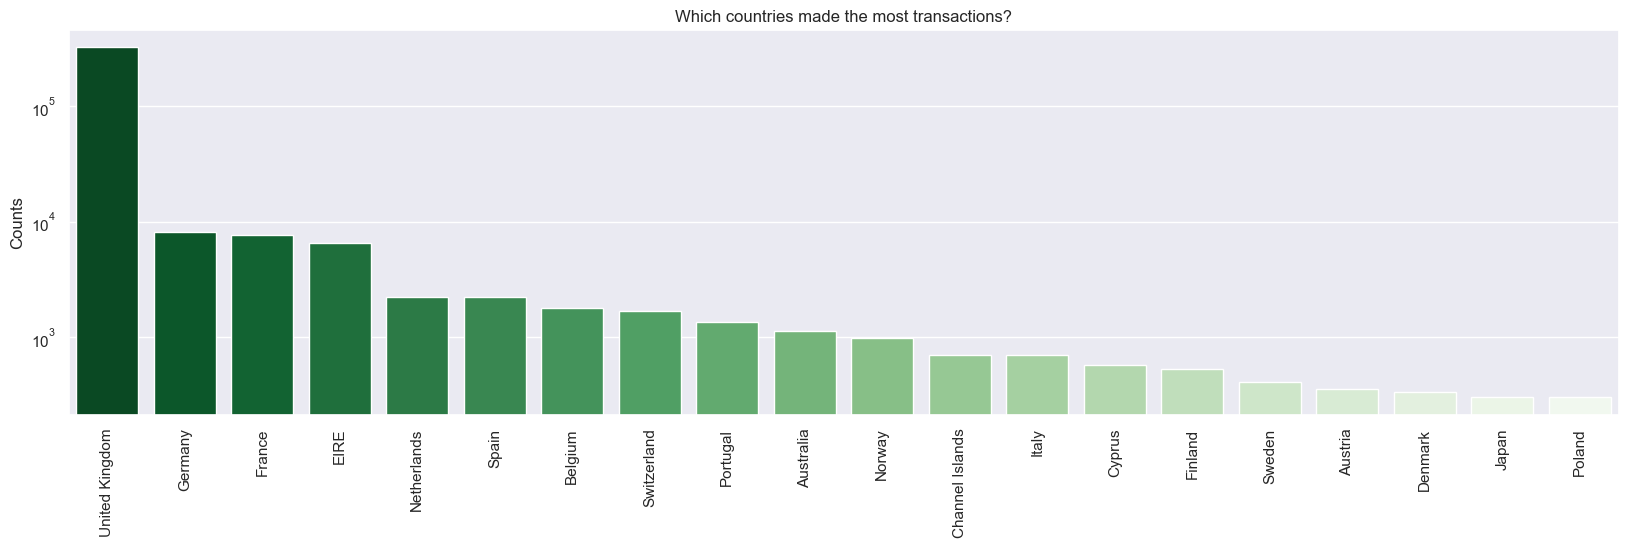

In [87]:
# Which ones are most common?
country_counts = data.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(x=country_counts.index, y=country_counts.values, palette="Greens_r")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

- We can see that the retailer sells almost all products in the UK, followed by many European countries.

In [88]:
# How many percentages of entries are inside the UK?
data.loc[data.Country=="United Kingdom"].shape[0] / data.shape[0] * 100

89.10192031784572

#### Create a feature to indicate inside or outside of the UK:

In [89]:
data["UK"] = np.where(data.Country == "United Kingdom", 1, 0)

### Unit Price 

In [90]:
data.UnitPrice.describe()

count    362440.000000
mean          2.885355
std           4.361812
min           0.000000
25%           1.250000
50%           1.790000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

- We have strange occurrences: zero unit prices!

In [91]:
data.loc[data.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,StockCodeLength,nNumericStockCode,UpCharsInDescription,UK
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256,United Kingdom,asstd design 3d paper stickers,30,0,5,5,25,1
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911,EIRE,set of 6 nativity magnets,26,0,5,5,20,0
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415,Australia,biscuit tin vintage christmas,29,0,5,5,26,0
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646,Netherlands,set of 2 ceramic christmas reindeer,35,0,5,5,29,0
314748,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.0,14646,Netherlands,polkadot rain hat,18,0,5,5,15,0


- That's not good again. It's not obvious if they are gifts to customers or not. 
- Let's drop them:

In [92]:
data = data.loc[data.UnitPrice > 0].copy()

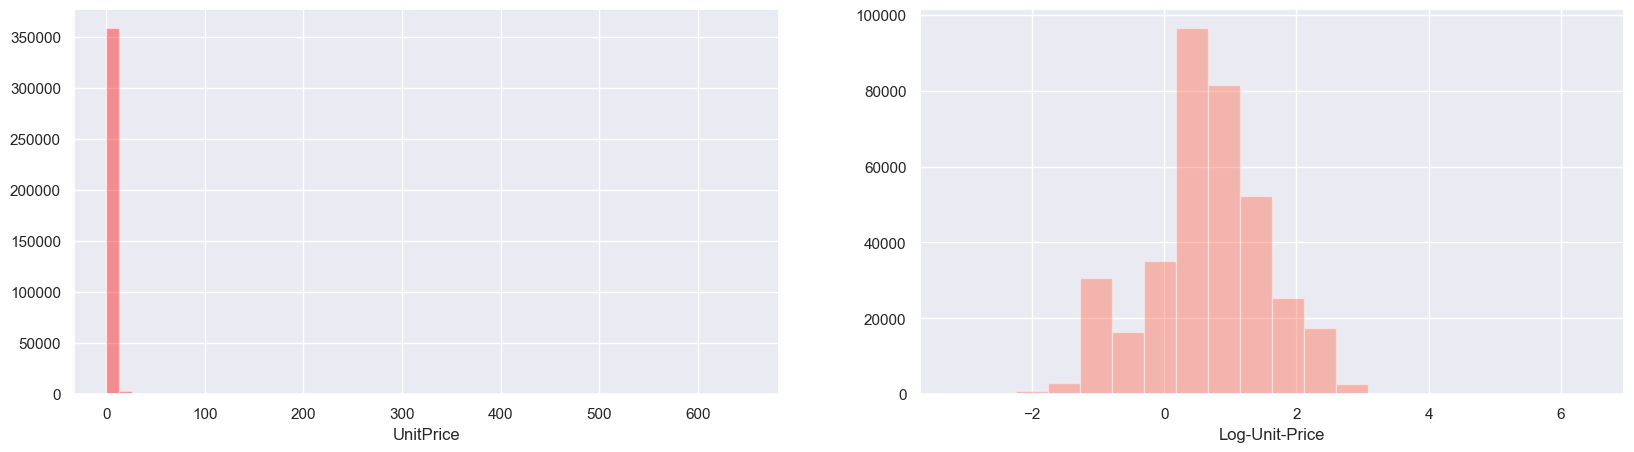

In [93]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.UnitPrice, ax=ax[0], kde=False, color="red")
sns.distplot(np.log(data.UnitPrice), ax=ax[1], bins=20, color="tomato", kde=False)
ax[1].set_xlabel("Log-Unit-Price");

In [94]:
np.exp(-2)

0.1353352832366127

In [95]:
np.exp(3)

20.085536923187668

In [96]:
np.quantile(data.UnitPrice, 0.95)

8.5

- Focus on transactions with prices that fall into this range, as we don't want to make predictions for very seldom products with high prices.

In [97]:
data = data.loc[(data.UnitPrice > 0.1) & (data.UnitPrice < 20)].copy()

In [98]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,StockCodeLength,nNumericStockCode,UpCharsInDescription,UK
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,white metal lantern,19,0,5,5,17,1
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,set 7 babushka nesting boxes,28,0,5,5,23,1
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,glass star frosted t-light holder,33,0,5,5,28,1
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,hand warmer union jack,22,0,5,5,19,1
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,hand warmer red polka dot,25,0,5,5,21,1


### Quantities

- The most important one - is the target. 
- Let's take a look at its distribution:

In [99]:
data.Quantity.describe()

count    361608.000000
mean         13.024112
std         187.566510
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

- Most products are sold in quantities from 1 to 12. 
- But, we have extreme, unrealistic outliers again:

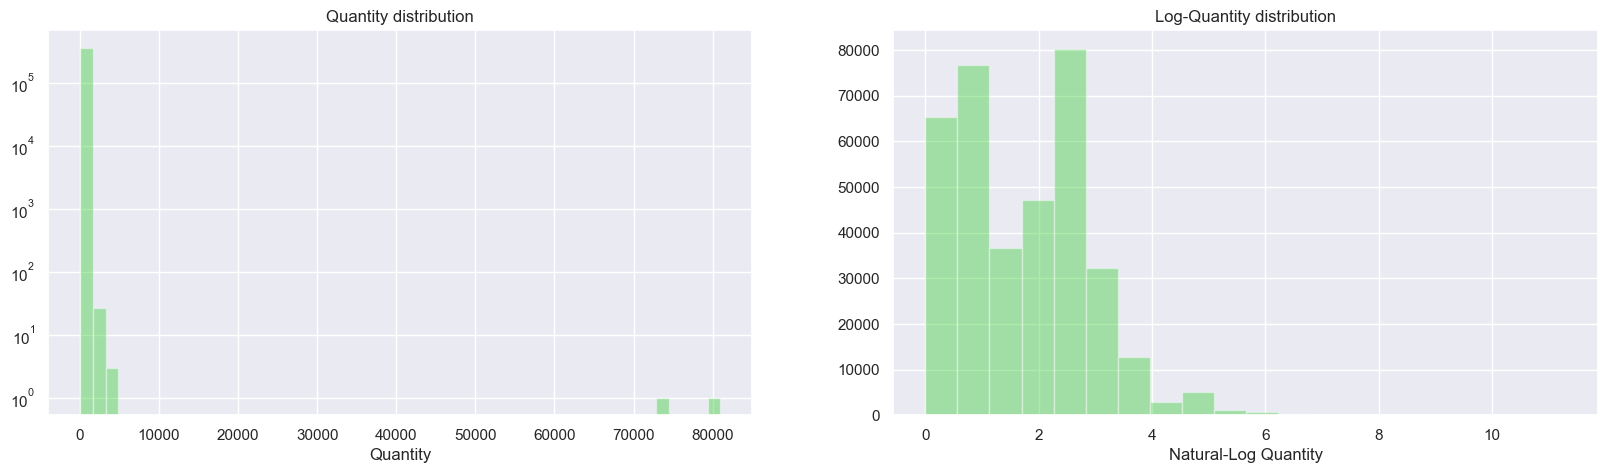

In [100]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.Quantity, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(data.Quantity), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");

- As you can see by the log-transformed distribution it would make sense to make a cut.

In [101]:
np.exp(4)

54.598150033144236

In [102]:
np.quantile(data.Quantity, 0.95)

36.0

- In this case we would still cover more than 95 % of the data!

In [103]:
data = data.loc[data.Quantity < 55].copy()

In [104]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,StockCodeLength,nNumericStockCode,UpCharsInDescription,UK
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,white metal lantern,19,0,5,5,17,1
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850,United Kingdom,set 7 babushka nesting boxes,28,0,5,5,23,1
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,glass star frosted t-light holder,33,0,5,5,28,1
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,hand warmer union jack,22,0,5,5,19,1
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850,United Kingdom,hand warmer red polka dot,25,0,5,5,21,1


## Revenues

#### Focus on daily product sales:
- We like to predict the daily amount of product sales, and we need to compute a daily aggregation of this data. 
- For this purpose, we need to extract temporal features out of the InvoiceDate. 
- We can compute the revenue gained by a transaction using the unit price and the quantity.

In [105]:
data["Revenue"] = data.Quantity * data.UnitPrice

data["Year"] = data.InvoiceDate.dt.year
data["Quarter"] = data.InvoiceDate.dt.quarter
data["Month"] = data.InvoiceDate.dt.month
data["Week"] = data.InvoiceDate.dt.week
data["Weekday"] = data.InvoiceDate.dt.weekday
data["Day"] = data.InvoiceDate.dt.day
data["Dayofyear"] = data.InvoiceDate.dt.dayofyear
data["Date"] = pd.to_datetime(data[['Year', 'Month', 'Day']])

- The key task of this kernel is to predict the number of products sold per day, we can sum up the daily quantities per product stock code:

In [106]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day",
                    "StockCode"]

- This way we lose information abount customers, countries, and price information but we will recover it later on during this kernel. 
- Besides the quantities let's aggregate the revenues as well:

In [107]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [108]:
# How are the quantities and revenues distributed?
daily_data.loc[:, ["Quantity", "Revenue"]].describe()

,Quantity,Revenue
count,195853.000000,195853.000000
mean,14.964244,28.181114
std,18.809496,43.938183
min,1.000000,0.120000
25%,3.000000,6.950000
50%,9.000000,15.300000
75%,20.000000,30.600000
max,411.000000,1266.300000


- As we can see by the min and max values the target variable shows extreme outliers. 
- If we would like to use them as targets, we should exclude them as they will mislead our validation. 
- As I like to use early stopping this will directly influence the training of predictive models as well.

In [109]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 88.48000000001048)


In [110]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(0.78, 204.0)


- Only use target ranges data that are occupied by 90 % of the data entries. 
- This is a first and easy strategy to exclude heavy outliers but we should always be aware of the fact that we have lost some information given by the remaining % we have excluded.
- It could be nice and useful in general to understand and analyze what has caused these outliers.

In [111]:
samples = daily_data.shape[0]

In [112]:
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

In [113]:
# How much entries have we lost?
samples - daily_data.shape[0]

5258

#### Take a look at the remaining distributions of daily quantities:

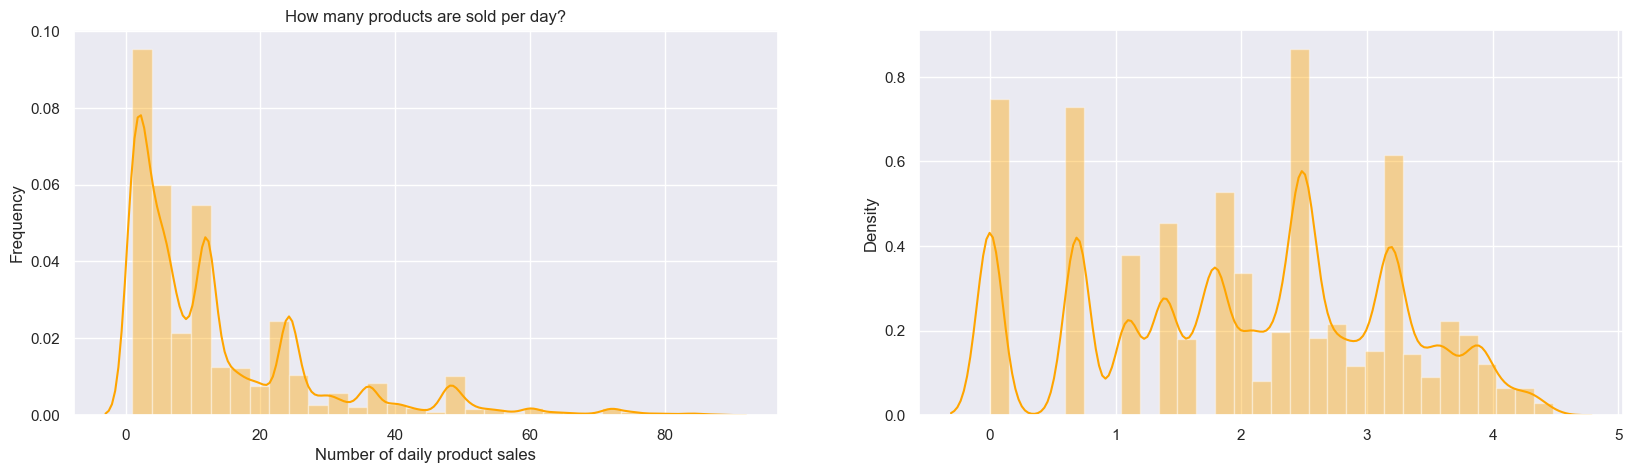

In [114]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

- We can see that the distributions are right-skewed. 
- Lower values are more common. In addition, the daily sales quantities seem to be multimodal. 
- A daily sale of 1 is common as well as a quantity of 12 and 24. This pattern is very interesting and leads to the conclusion that quantities are often divisible by 2 or 3. 
- In a nutshell, we can say that specific product are often bought in single quantities or a small bunch.